# V. Введение в пространственную статистику (1)


## Пространственная статистика точек (Spatial Point Analysis)


Пространственная статистика точек — это набор методов для анализа распределения точек в пространстве. Эти методы позволяют изучать закономерности и кластеризацию точек, а также проводить проверку гипотез о случайности распределения объектов.


В этом разделе мы изучим данные о ДТП с Санкт-Петербурге за 2023 год

В дополнение к основной теме мы познакомимся с библиотеками seaborn и contextily. Seaborn - крутая библиотека для визуализации на основн matplotlib. Contextily помогает добавлять базовые карты (подложки).


Импортируем библиотеки


In [1]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import contextily
import seaborn
import osmnx as ox

Читаем данные о ДТП и перепроецируем в подходящую UTM-зону


In [2]:
accidents = gpd.read_file('data/spb_dtp.gpkg')

target_utm = accidents.estimate_utm_crs()
accidents_utm = accidents.to_crs(target_utm)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


### 1. Расстояние до ближайшего соседа (Nearest Neighbor Distance)

Этот метод используется для измерения расстояний между точками и анализа их пространственного распределения


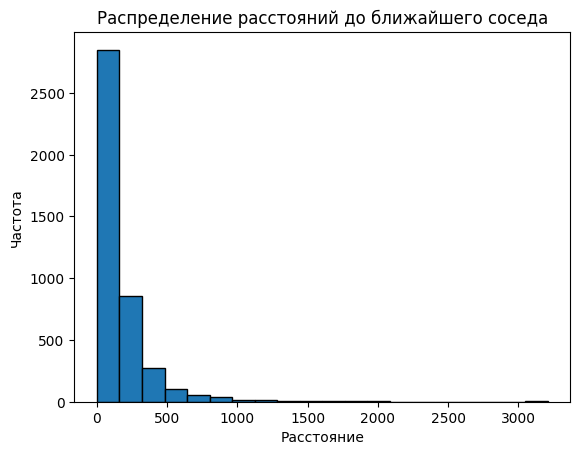

In [3]:
# Расчёт расстояний до ближайшего соседа
distances = []
for point in accidents_utm.geometry:
    dist = accidents_utm.geometry.distance(point)
    dist = dist[dist > 0]  # исключаем нулевые значения
    distances.append(np.min(dist))

# Визуализация гистроаммы распределения
plt.hist(distances, bins=20, edgecolor='black')
plt.title("Распределение расстояний до ближайшего соседа")
plt.xlabel("Расстояние")
plt.ylabel("Частота")
plt.show()


### 2. Nearest Neighbour Index


NNI (Nearest Neighbor Index, индекс ближайшего соседа) — это статистическая мера, которая позволяет оценить, насколько равномерно распределены объекты в пространстве. Мы с ним уже познакомились пару недель назад.

NNI рассчитывается как отношение двух величин:

- наблюдаемого среднего расстояния до ближайшего соседа между всеми объектами в выборке (robs)
- ожидаемого среднего расстояния между точками при полностью случайном (гомогенном пуассоновском) распределении (rexp)

Интерпретация значения:

- NNI < 1 — объекты имеют склонность к кластеризации (сосредоточены ближе друг к другу, чем при случайном распределении);
- NNI ≈ 1 — распределение близко к случайному;
- NNI > 1 — объекты расположены более равномерно (регулярно), чем при случайном распределении.


In [4]:
#  Вычисление среднего расстояния до ближайшего соседа
average_nearest_neighbor_distance = np.mean(distances)

# Вычисление площади Санкт-Петербурга
spb_area = ox.geocode_to_gdf("Санкт-Петербург")
spb_area = spb_area.to_crs(spb_area.estimate_utm_crs())
spb_area = spb_area.area.values[0] 

# Расчет ожидаемого среднего расстояния для случайного распределения точек
n = len(distances)
expected_mean_distance = 0.5 * np.sqrt(spb_area / n)

# Расчет NNI
NNI = average_nearest_neighbor_distance / expected_mean_distance
NNI



0.42037362841769255

Альтернативно можно подумать о том, как считать площадь территории без учеба административных границ, например, создавая выпуклую оболчку вокруг точек:

1. Создание выпуклой оболочки (convex hull)
   convex_hull = accidents.geometry.unary_union.convex_hull

2. Создание нового GeoDataFrame для выпуклой оболочки
   convex_hull_gdf = gpd.GeoDataFrame(
   {'geometry': [convex_hull]},
   crs=accidents.crs # Убедитесь, что координатная система одинакова
   )

Но это тоже неидеальный вариант для Санкт-Петербурга, почему?


### 3. Визуальное исследование точек


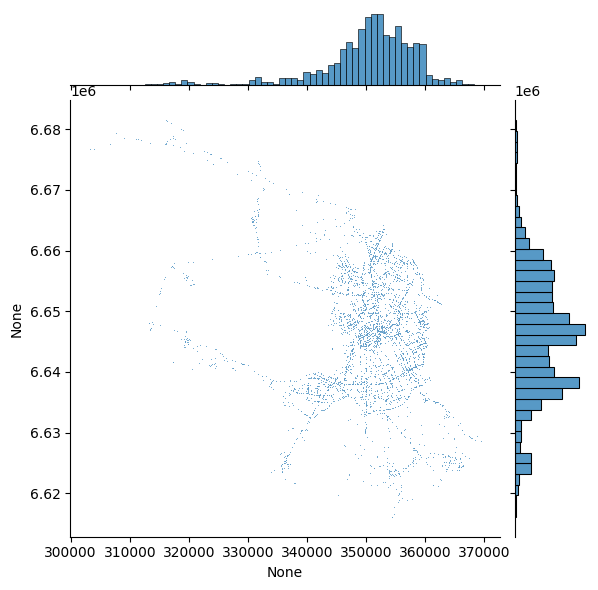

In [5]:
seaborn.jointplot(x=accidents_utm.geometry.x, y=accidents_utm.geometry.y, data=accidents_utm, s=0.5);

Это хороший старт: благодаря гистроамме мы видим, что точки склонны сосредотачиваться в центре города и на юге. Но без знания города, тяжело оценить размещение объектов. Давайте добавим на карту basemap


Сделаем это с помощью библиотеки contextily


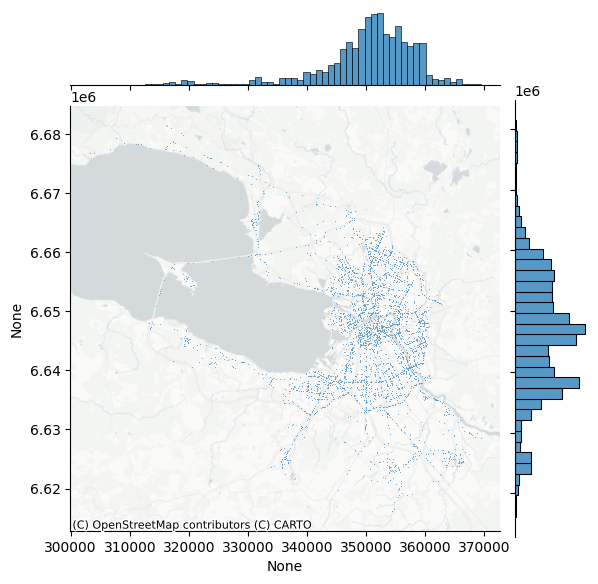

In [6]:
joint_axes = seaborn.jointplot(
    x=accidents_utm.geometry.x, y=accidents_utm.geometry.y, data=accidents_utm, s=0.5
)
contextily.add_basemap(
    joint_axes.ax_joint,
    source=contextily.providers.CartoDB.PositronNoLabels,
    crs=target_utm,
)

### 4. Плотность на основе регулярной сетки


Отобразим плотность на основе ячеек регулярной сетки


Когда слишком много точек сосредоточено в одной области, плотное наложение точек затрудняет выявление паттернов. Например, на карте видно, что в центре города сосредоточено очень много аварий, но трудно понять, является ли это равномерным распределением или есть места с особенно высокой концентрацией. Поэтому можно наложить точки на сетку и наглядно увидеть концентрацию


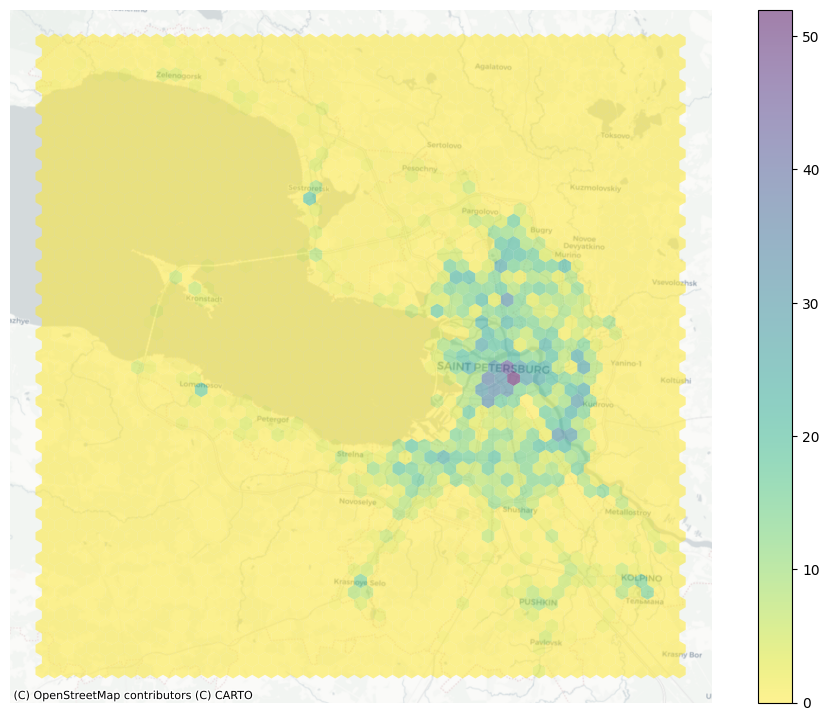

In [7]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    accidents_utm.geometry.x,
    accidents_utm.geometry.y,
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap="viridis_r",
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron,
    crs=target_utm,
)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

### 5. Плотностная модель (Kernel Density Estimation)


Альтернативный подход оценка плотности с помощью KDE (kernel density estimation): эмпирическая аппроксимация функции плотности вероятности.

Вместо того чтобы накладывать сетку квадратов или гексагонов и подсчитывать, сколько точек попадает в каждую, KDE накладывает сетку точек на интересующее пространство и размещает функции ядра, которые учитывают точки вокруг них с разным весом в зависимости от расстояния. Эти подсчеты затем агрегируются, чтобы создать глобальную поверхность с вероятностью плотности.


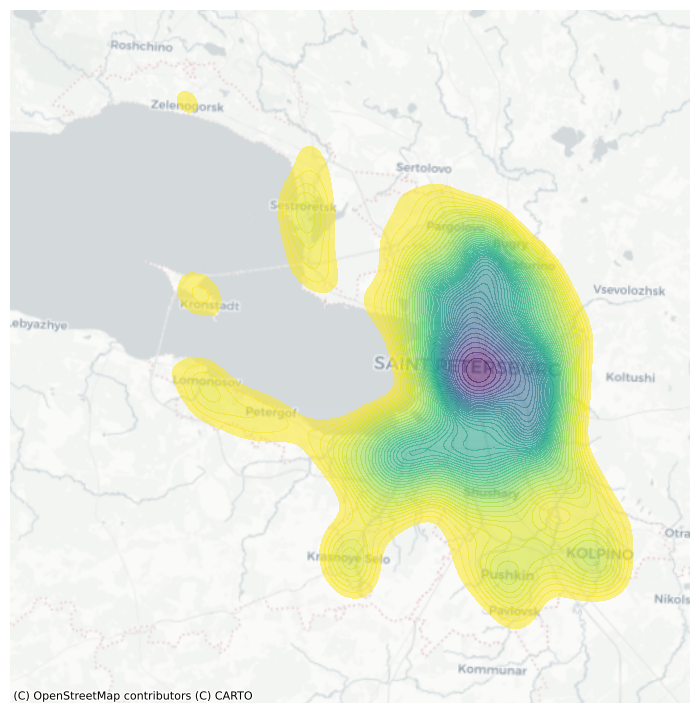

In [8]:

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients
# coloured contours, 75% of transparency,
# and the reverse viridis colormap

seaborn.kdeplot(
    x=accidents_utm.geometry.x,
    y=accidents_utm.geometry.y,
    levels=50,
    fill=True,
    alpha=0.55,
    cmap="viridis_r",
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron,
    crs=target_utm,
)
# Remove axes
ax.set_axis_off()

### 6. Центрография


Это раздел пространственного анализа, посвящённый выявлению «центров» точечного распределения и оценке его структуры.
Главные задачи центрографии:

- Определить «центр тяжести» набора точек, чтобы получить представление о том, где сосредоточена максимальная масса событий (например, аварий, преступлений, точек продаж и т. д.)
- Сравнить разные распределения: сместился ли центр события со временем, отличается ли он между двумя категориями объектов.
- Оценить степень разброса: помимо центра важно знать, насколько распределены точки вокруг него.


In [9]:
from pointpats import centrography

Определим средний и медианный центр нашего набора данных


In [13]:
# Извлечение координат x и y
accidents_utm["x"] = accidents_utm.geometry.x
accidents_utm["y"] = accidents_utm.geometry.y

# Вычисление среднего центра (mean center)
mean_center = centrography.mean_center(accidents_utm[["x", "y"]])

# Вычисление медианного центра (Euclidean median)
med_center = centrography.euclidean_median(accidents_utm[["x", "y"]])

Отобразим на карте


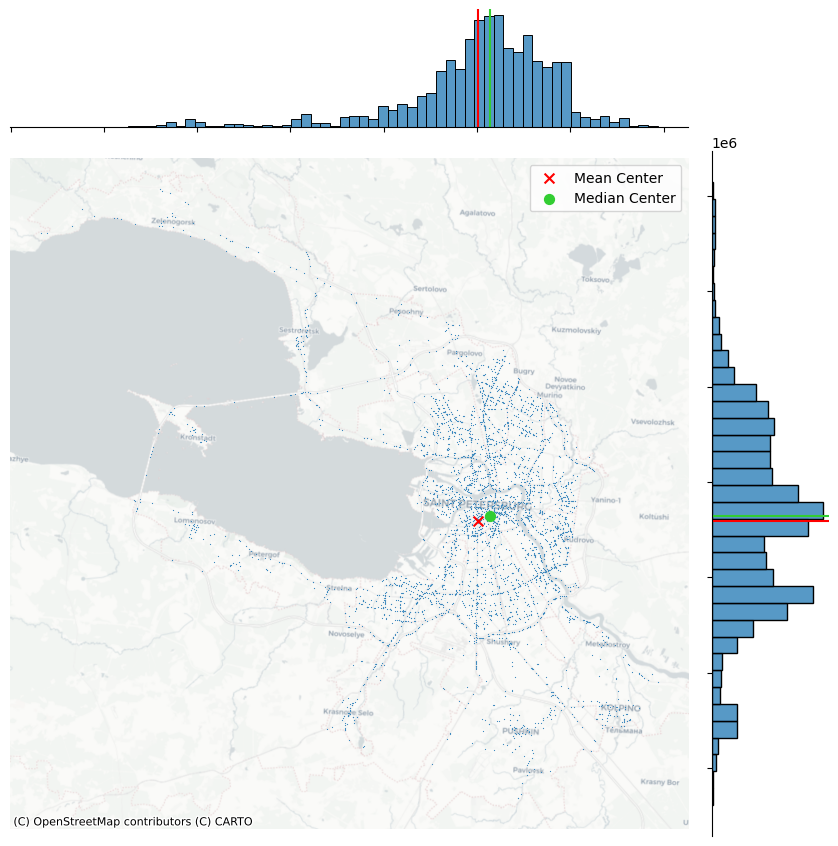

In [14]:
# Generate scatterplot
joint_axes = seaborn.jointplot(
    x="x", y="y", data=accidents_utm, s=0.75, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color="red", marker="x", s=50, label="Mean Center"
)
joint_axes.ax_marg_x.axvline(mean_center[0], color="red")
joint_axes.ax_marg_y.axhline(mean_center[1], color="red")
# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center,
    color="limegreen",
    marker="o",
    s=50,
    label="Median Center"
)
joint_axes.ax_marg_x.axvline(med_center[0], color="limegreen")
joint_axes.ax_marg_y.axhline(med_center[1], color="limegreen")
# Legend
joint_axes.ax_joint.legend()
# Add basemap
contextily.add_basemap(

    joint_axes.ax_joint, source=contextily.providers.CartoDB.Positron, crs= target_utm,
)
# Clean axes
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

Посчитаем стандартное расстояние (пространственный аналог среднего отклонения) - мреднее расстояние точек от центра


In [15]:
centrography.std_distance(accidents_utm[["x", "y"]])

13387.089449467901

## Итог


В этом резделе мы познакомились с основами анализа пространственного распределения точек на примере данных ДТП в Санкт-Петербурге.
